In [1]:
from analyze_partition_agg import *
from analyze_synthgraph import *

### Results Per-Fraud Detector Subsample-and-Aggregate

In [2]:
res_bias = analyze_pda_validation_results_oneshot(stat='aucs', eps=1000., n_noise_draws=50)

In [3]:
# fixing sub_rate, increasing k increases the bias
stats = [c for c in res_bias.columns if 'bias' in c]
df = res_bias.melt(id_vars=['dataset', 'sub_rate', 'k', 'method', 'eps'], value_vars=stats, var_name='algo', value_name='bias')
df['algo'] = ['_'.join(a.split('_')[1:]) for a in df['algo']]
df = df[~df.algo.isin(['agg1', 'agg2', 'agg_max', 'random'])]
df['algo'] = df['algo'].map(ALGORITHM_NAMES)
df.head()

,dataset,sub_rate,k,method,eps,algo,bias
0,amazon_sbm,0.05,20,laplace,1000.0,Clustering Coeff,-0.419020
1,amazon_sbm,0.05,50,laplace,1000.0,Clustering Coeff,-0.423009
2,amazon_sbm,0.05,100,laplace,1000.0,Clustering Coeff,-0.423363
3,amazon_sbm,0.05,200,laplace,1000.0,Clustering Coeff,-0.423422
4,amazon_sbm,0.10,10,laplace,1000.0,Clustering Coeff,-0.403569


In [4]:
def plot_bias_vs_param(plot, datasets, fixed_param_name, fixed_param_value):
    plot = df[(df[fixed_param_name] == fixed_param_value) & (df['dataset'].isin(datasets))].copy()
    plot['abs_bias'] = plot['bias'].abs()

    if fixed_param_name == 'k':
        x_label = 'Fraud Subsample Rate'
        param_name = 'sub_rate'
    if fixed_param_name == 'sub_rate':
        x_label = 'Number of Partitions'
        param_name = 'k'

    markers = ['o', 's', 'v', 'D', '<', 'd', '>']

    g = sns.relplot(data=plot, x=param_name, y='bias', col='dataset', kind='line', col_order=datasets,
                    hue='algo', style='algo', markers=markers, dashes=False, lw=3, markersize=8)

    # add horizontal line at 0 to each subplot  
    for ax in g.axes.flat:
        ax.axhline(0, ls='--', color='black')

    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16)
        
    g.set_ylabels('Bias of AUC Score', fontsize=16)
    g.set_xlabels(x_label, fontsize=16)

    # increase fontsize of x and y tick labels
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=14)

    # move legend outside plot to the botom and split into two rows
    g.figure.legend(title='Fraud Detector', ncols=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=12, title_fontsize=14)
    g._legend.set_visible(False)

    plt.tight_layout()
    save_path=f"results/figures/bias_vs_{param_name}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)
    plt.show()


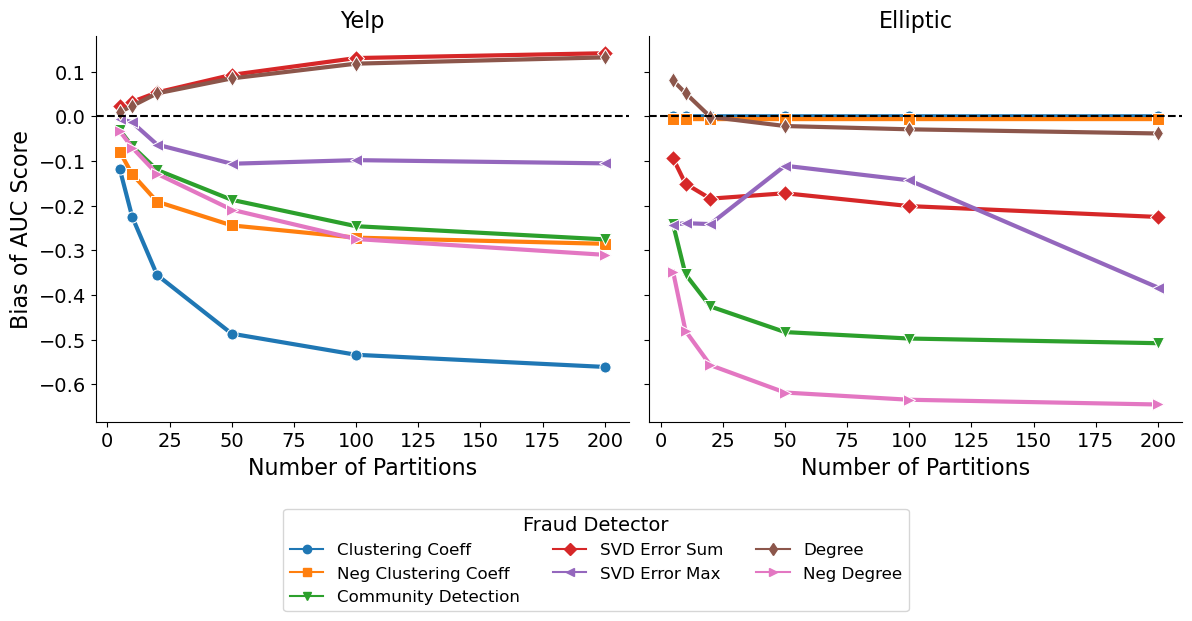

In [5]:
SUB_RATE = 0.25
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

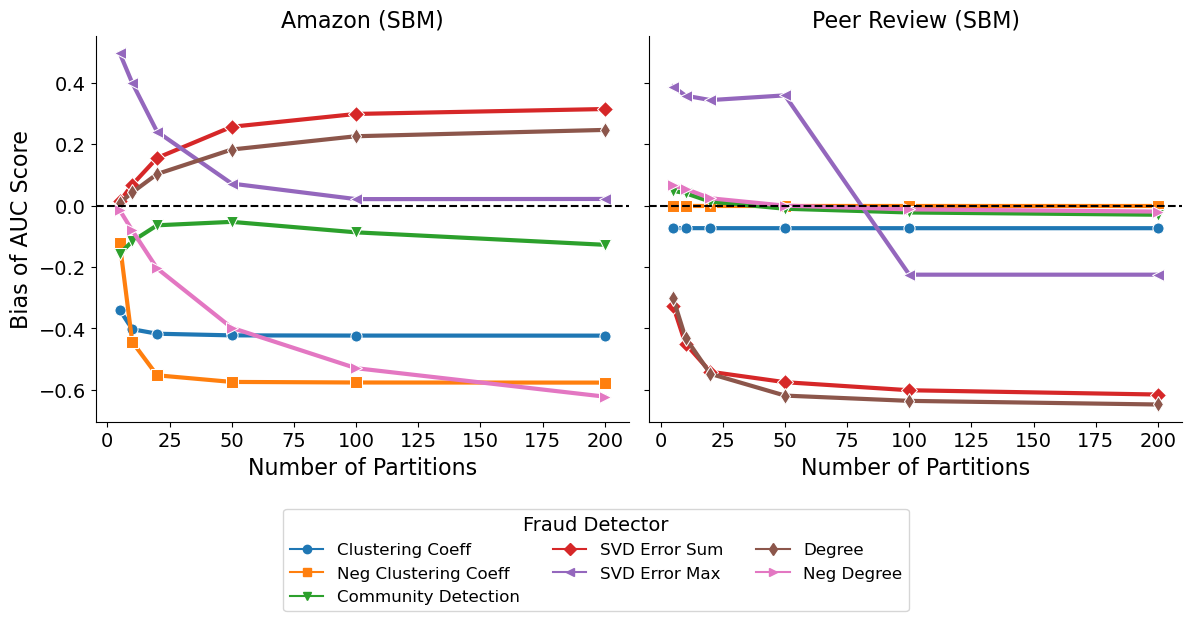

In [6]:
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

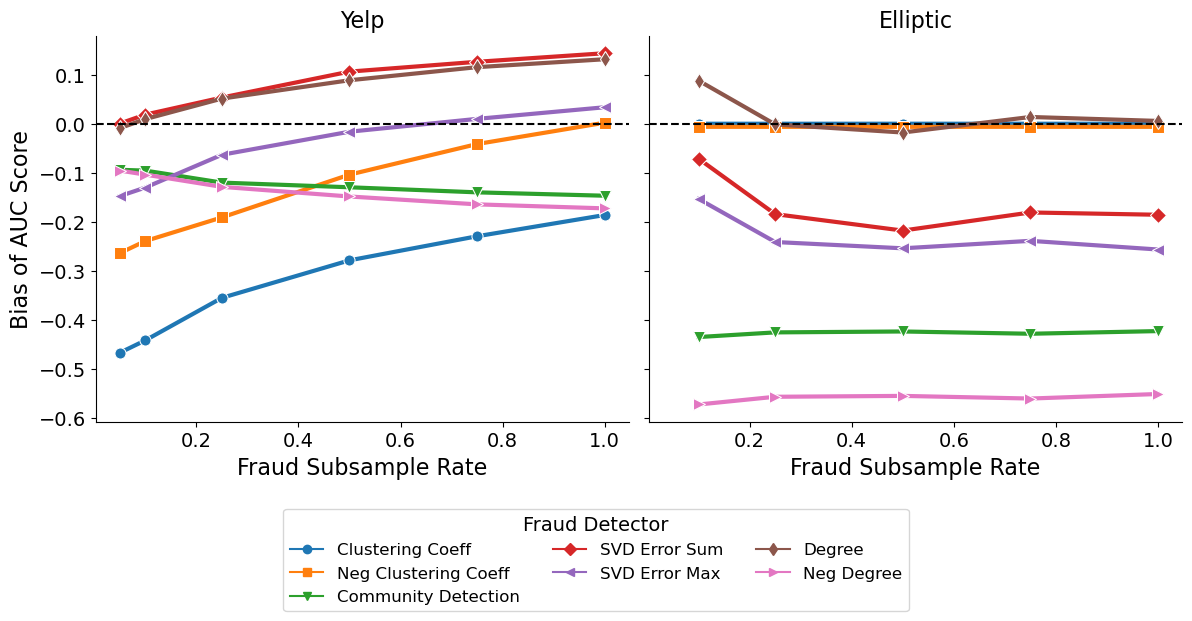

In [7]:
K = 20
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'k', K)

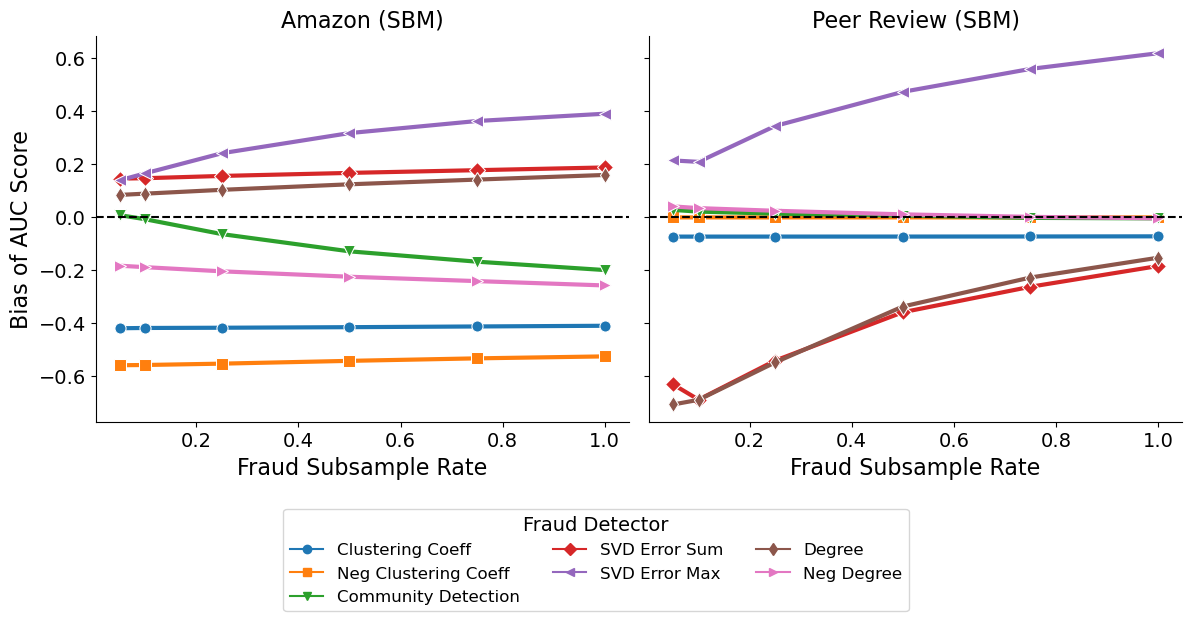

In [8]:
K = 20
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'k', K)

## Results for Leaderboard Subsample-and-Aggregate 

In [14]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [10]:
random_baselines = get_leaderboard_baselines(split='val')

=== Kendall Tau Baseline for Validation Sets ===
Test vs. Val yelp: 0.0033
Random: 5.2972
Test vs. Val elliptic: 0.021
Random: 5.8816
Test vs. Val amazon_sbm: 0.5359
Random: 8.1541
Test vs. Val peer_review_sbm: 1.1187
Random: 8.5293


In [58]:
def add_hatches(g, n_bars=2, plot_type='catplot'):
    # hatches for each bar
    hatches = ['//', '..', 'xx', '++', 'oo', 'O', '||', '\\\\', '|||', '---', '///', '+++']
    hatches = hatches[:n_bars]

    # iterate through each subplot / Facet
    iter_ax = g.axes.flat if plot_type == 'catplot' else [g.axes]
    for ax in iter_ax:
        # select the correct patches
        patches = [patch for patch in ax.patches]

        # the number of patches should be evenly divisible by the number of hatches
        h = [[hatch]*(len(patches) // n_bars) for hatch in hatches]
        h = [item for sublist in h for item in sublist]
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

    return hatches


def plot_k_vs_kendalltau(df, sub_rate, datasets, eps, random_baselines):
    df = df[df['sub_rate'] == sub_rate]

    max_eps = df.eps.max()
    df = df[df.eps.isin([max_eps, eps])]
    df['eps'] = df['eps'].astype(str)

    # get results with no noise
    g = sns.catplot(data=df, x='k', y='dist', col='dataset', kind='bar',
                     col_order=datasets,hue='eps', errorbar=("ci", 95), capsize=0.05, errwidth=1.5, palette='colorblind', hue_order=[str(max_eps), str(eps)])       
    
    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.axhline(random_baselines[datasets[i]], ls='--', color='black') # add line for random baseline
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16) # set title to just dataset name
        ax.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    
    _ = add_hatches(g)
        
    g.set_ylabels('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabels('Number of Partitions (k)', fontsize=16)      

    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()
    l = g.figure.legend(handles, ['No Noise', f'Laplace Noise ($\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)})'], ncol=2, loc='lower center', 
                bbox_to_anchor=(0.5, -0.1), frameon=False, fontsize=16)

    plt.tight_layout()

    save_path=f"results/figures/kendall_tau_nonoise_vs_{eps}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)

    plt.show()

In [16]:
SUB_RATE = 0.5
EPS = 5.
DATASETS = ['yelp', 'elliptic']

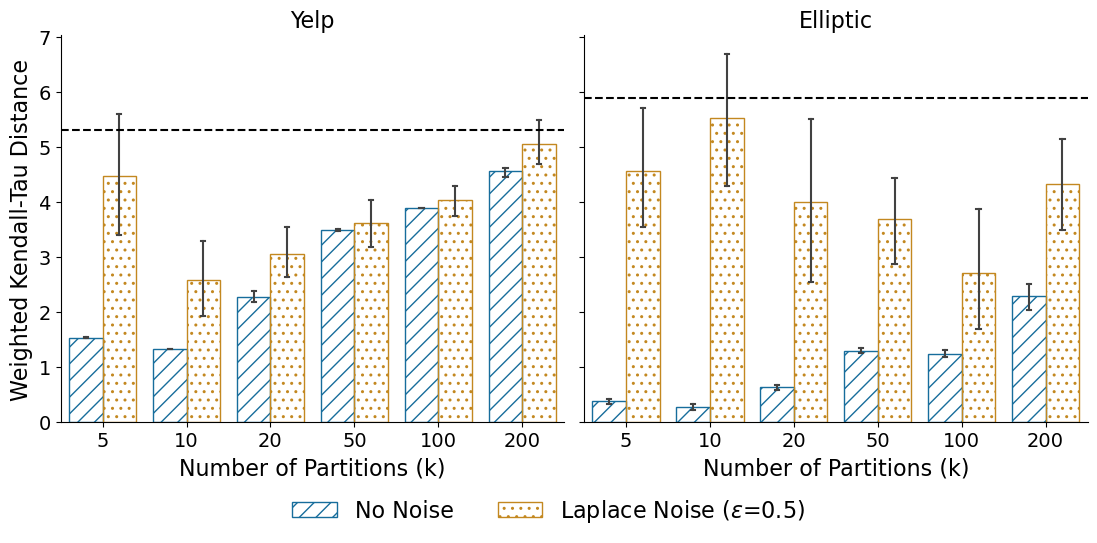

In [17]:
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, EPS, random_baselines)

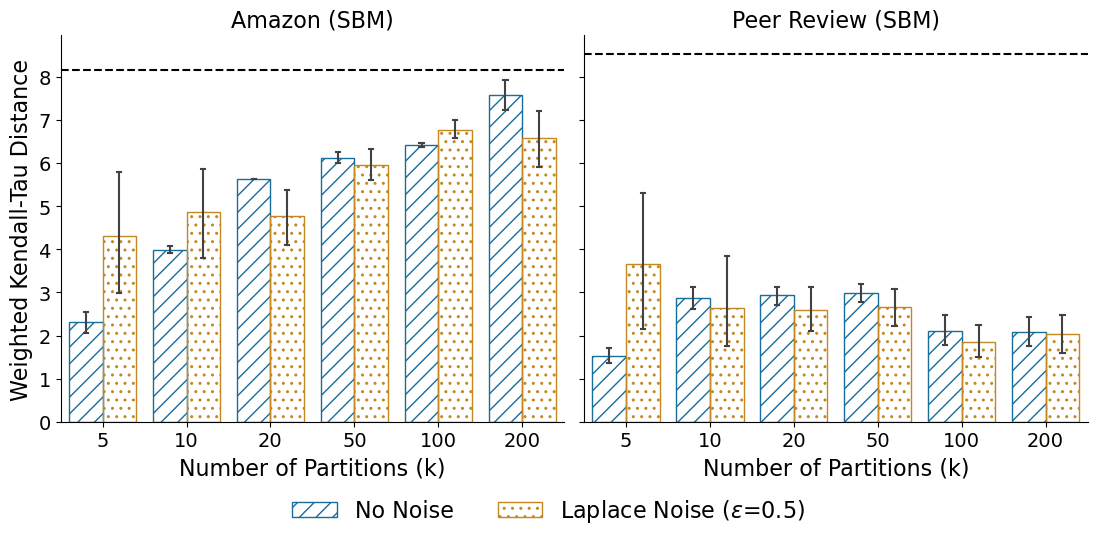

In [18]:
SUB_RATE = 0.5
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, EPS, random_baselines)

## Params for Partition-Aggregate

In [20]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [41]:
# grid search over all k,sub_rate combos to see best performing in terms of kendall-tau
def get_best_params(df, datasets, eps, pooled=False, top=5):
    df = df[df['dataset'].isin(datasets) & (df['eps'] == eps)]
    if pooled:
        df = df.groupby(['sub_rate', 'k'])['dist'].mean().reset_index()
        return df.sort_values(by='dist', ascending=True).head(top)
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    best = [df[df['dataset'] == dataset].sort_values(by='dist', ascending=True).head(top) for dataset in datasets]
    return pd.concat(best)

def get_values(df, datasets, eps, sub_rate, k):
    df = df[(df['dataset'].isin(datasets)) & (df['eps'] == eps) & (df['sub_rate'] == sub_rate) & (df['k'] == k)]
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    return df

In [93]:
def plot_best_pooled_vs_best_unpooled(df, datasets, eps, ax):
    best_pooled = get_best_params(df, datasets, eps, pooled=True, top=1)
    best_unpooled = get_best_params(df, datasets, eps, pooled=False, top=1)

    best_pooled_subrate = best_pooled['sub_rate'].values[0]
    best_pooled_k = best_pooled['k'].values[0]

    best_pooled_by_dataset = df[(df['dataset'].isin(datasets)) & (df['eps'] == eps) & (df['sub_rate'] == best_pooled_subrate) & (df['k'] == best_pooled_k)]
    best_pooled_by_dataset = best_pooled_by_dataset.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()

    best_unpooled['kind'] = 'Per Dataset'
    best_pooled_by_dataset['kind'] = 'Averaged'  

    g = sns.barplot(data=pd.concat([best_unpooled, best_pooled_by_dataset]), x='dataset', y='dist', hue='kind', palette='colorblind', ax=ax)
    _ = add_hatches(g, n_bars=2, plot_type='barplot')  

    g.legend(title='', fontsize=13)
    g.set_ylabel('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabel('', fontsize=16)

    def reformatter(x):
        if 'sbm' in x:
            return '\n'.join(DATASET_NAMES[x].split(' '))
        return DATASET_NAMES[x]
    
    g.set_xticklabels([reformatter(d) for d in datasets], fontsize=14)
    g.axes.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    g.set_title(f'$\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)} per fraud detector', fontsize=16)

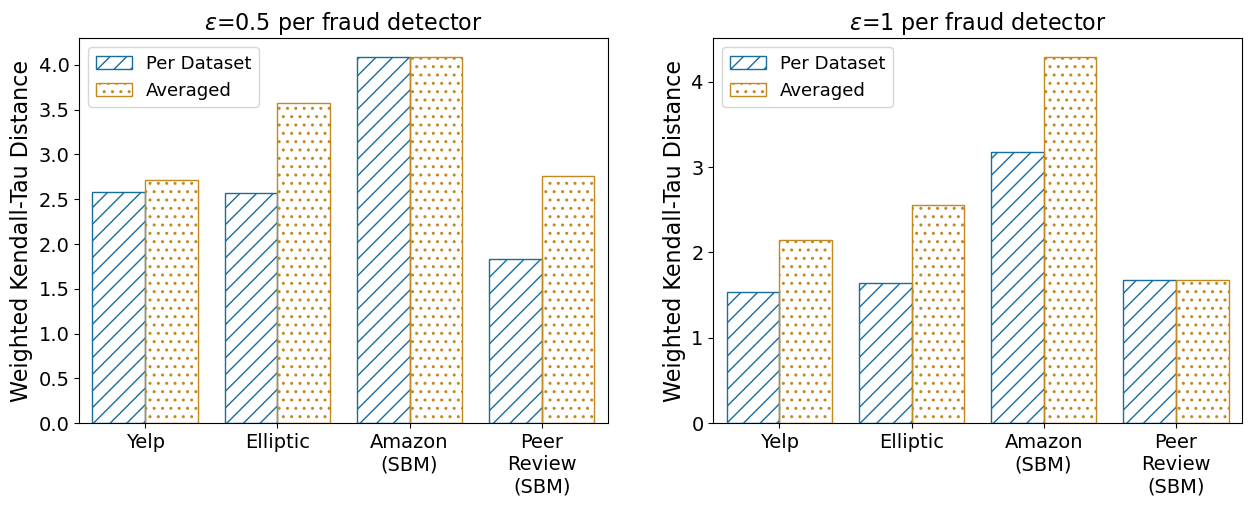

In [97]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
for i, eps in enumerate([5., 10.]):
    plot_best_pooled_vs_best_unpooled(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], eps, axes.ravel()[i])

plt.tight_layout()
plt.savefig('results/figures/best_pooled_vs_best_unpooled.pdf')

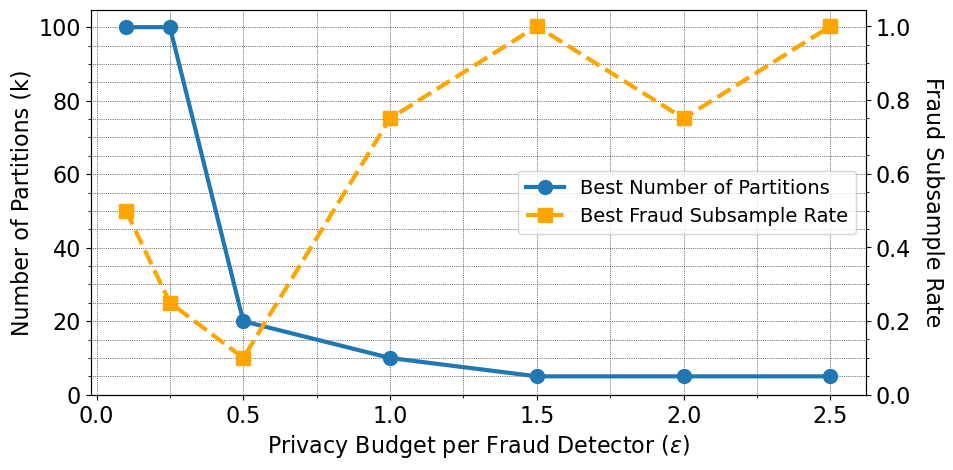

In [164]:
# setup ax for plot
fig, ax = plt.subplots(figsize=(10, 5))

best_k_avg = [get_best_params(df, DATASETS, eps, pooled=True, top=1)['k'].values[0] for eps in df.eps.unique()][:-1]
ax.plot([e/10. for e in df.eps.unique()[:-1]], best_k_avg, marker='o', markersize=10, lw=3, label='Best Number of Partitions')
plt.xlabel('Privacy Budget per Fraud Detector ($\epsilon$)', fontsize=16)
plt.ylabel('Number of Partitions (k)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 110, 20), fontsize=16)
# add minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.25))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


best_subrate_avg = [get_best_params(df, DATASETS, eps, pooled=True, top=1)['sub_rate'].values[0] for eps in df.eps.unique()][:-1]
# plot with second y-axis
ax2 = plt.twinx()
ax2.plot([e/10. for e in df.eps.unique()[:-1]], best_subrate_avg, marker='s', markersize=10, lw=3, color='orange', linestyle='--', label='Best Fraud Subsample Rate')
# flip ylabel text orientation on right side
plt.ylabel('Fraud Subsample Rate', fontsize=16, rotation=270, labelpad=24)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=16)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=14)

# ax.legend(title='', fontsize=16)

# # add grid for minor ticks
plt.savefig('results/figures/best_k_vs_eps.pdf')
plt.show()

In [143]:
for eps in df.eps.unique()[:-1]:
    d = get_best_params(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], eps, pooled=True, top=1)
    print(f'eps={eps}, k={d.k.values[0]}, sub_rate={d.sub_rate.values[0]}')

eps=1.0, k=200, sub_rate=0.1
eps=2.5, k=50, sub_rate=0.25
eps=5.0, k=20, sub_rate=0.1
eps=10.0, k=10, sub_rate=0.75
eps=15.0, k=5, sub_rate=0.75
eps=20.0, k=5, sub_rate=0.75
eps=25.0, k=5, sub_rate=0.75


## Analyze Noise to Sufficient Statistics of Graph Models for Different Thresholds at varying epsilon

In [25]:
df = pd.read_csv('results/synthetic_param_estimation.csv', sep=',')
list_cols = ['sbm_params', 'sbm_params_err', 'degree_seq', 'degree_seq_err']
for c in list_cols:
    df[c] = df[c].replace(np.nan, '[]').apply(lambda x: np.array(ast.literal_eval(x)))

In [26]:
df.head()

,eps,deg_cutoff_rate,iters,non_private,iter,dataset,synthetic_algo,sbm_params,sbm_params_err,n_edges,n_triangles,degree_seq,n_edges_flipped,degree_seq_err,n_triangles_err,n_edges_err
0,1.0,1.0,10,False,0,yelp,sbm_dp,"[0.009882529969243369, 0.0041324636377779835]","[-0.0004570713395833006, 8.091149057462554e-06]",NaN,NaN,[],NaN,[],NaN,NaN
1,1.0,1.0,10,False,0,yelp,attr_graph_simp,"[0.009882529969243369, 0.0041324636377779835]","[5.572154727083098e-05, 8.41450851790564e-05]",NaN,NaN,"[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,"[254, -58, -63, -22, -18, -25, -37, -48, -39, ...",-27006702.0,NaN
2,1.0,1.0,10,False,0,yelp,attr_graph,"[0.009882529969243369, 0.0041324636377779835]","[0.0039913357928858025, -0.005267667762454983]",NaN,27006702.0,"[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,"[7922, -58, -63, -22, -18, -25, -37, -48, -39,...",-26859246.0,NaN
3,1.0,1.0,10,False,0,yelp,topmfilter,[],[],548207.0,NaN,[],1317412.0,[],NaN,269167.0
4,1.0,1.0,10,False,0,elliptic,sbm_dp,"[0.0002958047432429712, 0.00014964011552216918]","[-0.02209807860052193, 0.0006579051733237419]",NaN,NaN,[],NaN,[],NaN,NaN


In [35]:
def analyze_param_error(df):
    # analyze for sbm_dp
    df_sbm = df[df['synthetic_algo'] == 'sbm_dp'].copy()
    df_sbm['rel_err'] = df_sbm['sbm_params_err'].abs() / df_sbm['sbm_params']
    rel_err = df_sbm.groupby(['eps', 'dataset', 'deg_cutoff_rate'])['rel_err'].mean().reset_index()

    rel_err['rel_err'] = rel_err.rel_err.apply(lambda a: np.round(a, 3))
    return rel_err

In [36]:
analyze_param_error(df[df.eps == 5.])

,eps,dataset,deg_cutoff_rate,rel_err
0,5.0,amazon_sbm,0.25,"[1.0, 1.0]"
1,5.0,amazon_sbm,0.50,"[1.0, 0.995]"
2,5.0,amazon_sbm,0.75,"[0.428, 0.25]"
3,5.0,amazon_sbm,1.00,"[0.002, 0.001]"
4,5.0,elliptic,0.25,"[134.67, 0.231]"
5,5.0,elliptic,0.50,"[111.332, 0.254]"
6,5.0,elliptic,0.75,"[337.114, 0.818]"
7,5.0,elliptic,1.00,"[300.498, 14.967]"
8,5.0,peer_review_sbm,0.25,"[5.546, 0.62]"
9,5.0,peer_review_sbm,0.50,"[4.751, 0.163]"


In [38]:
analyze_param_error(df[df.eps == 5.])

,eps,dataset,deg_cutoff_rate,rel_err
0,5.0,amazon_sbm,0.25,"[1.0, 1.0]"
1,5.0,amazon_sbm,0.50,"[1.0, 0.995]"
2,5.0,amazon_sbm,0.75,"[0.428, 0.25]"
3,5.0,amazon_sbm,1.00,"[0.002, 0.001]"
4,5.0,elliptic,0.25,"[134.67, 0.231]"
5,5.0,elliptic,0.50,"[111.332, 0.254]"
6,5.0,elliptic,0.75,"[337.114, 0.818]"
7,5.0,elliptic,1.00,"[300.498, 14.967]"
8,5.0,peer_review_sbm,0.25,"[5.546, 0.62]"
9,5.0,peer_review_sbm,0.50,"[4.751, 0.163]"


## Analyze Graphs Generated with No Noise to Sufficient Statistics and With Noise